<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/03_Construct_Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graph Builder
This notebook provides information about how to create a Knowledge Graph from unstructured data.



In [ ]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

Cloning into 'Agentic_KAG'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 90 (delta 45), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 1.03 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (45/45), done.


## Install Required Packages

In [ ]:
!pip install -r /content/Agentic_KAG/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.4/764.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.3 MB/s e

## Load credentials from .env

In [ ]:
import os

os.chdir('/content/Agentic_KAG/')

from dotenv import load_dotenv
import prompts


load_dotenv()  # This loads .env at project root

NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Set OPENAI_API_KEY as env variable for openai/neo4j-graphrag compatibility
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Initialize the Neo4j Driver
The Neo4j driver allows you to connect and perform read and write transactions with the database.

In [ ]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
)

# (Optional) Test the connection
driver.verify_connectivity()

## Initialize OpenAI LLM and Embeddings via neo4j-graphrag
We will use OpenAI **GPT-4.1**. The GraphRAG Python package supports any LLM model, including models from OpenAI, Google VertexAI, Anthropic, Cohere, Azure OpenAI, local Ollama models, and any chat model that works with LangChain. You can also implement a custom interface for any other LLM.

Likewise, we will use OpenAI’s **text-embedding-3-small** for the embedding model, but you can use other embedders from different providers.

In [ ]:
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings

neo4j_answering_llm = OpenAILLM(
    model=DEPLOYMENT_NAME,
    api_key=OPENAI_API_KEY
)

llm = OpenAILLM(
    model_name="gpt-4.1",
    model_params={"temperature": 0}
)

json_llm = OpenAILLM(
    model_name="gpt-4.1",
    model_params={"temperature": 0,
                  "response_format": {"type": "json_object"}
                  }
)

embedder = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

We will also initialize langchain llm to use for community detection & Summarization

In [ ]:
from langchain_openai import ChatOpenAI

# Initialize OpenAI LLM using LangChain
lang_llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model_name="gpt-4.1", temperature=0)

## Pipeline Structure
A Knowledge Graph (KG) construction pipeline requires a few components (some of the below components are optional):

**Data loader:** extract text from files (PDFs, …).

**Text splitter:** split the text into smaller pieces of text (chunks), manageable by the LLM context window (token limit).

**Chunk embedder (optional):** compute the chunk embeddings.

**Schema builder:** provide a schema to ground the LLM extracted node and relationship types and obtain an easily navigable KG. Schema can be provided manually or extracted automatically using LLMs.

**Lexical graph builder:** build the lexical graph (Document, Chunk and their relationships) (optional).

**Entity and relation extractor:** extract relevant entities and relations from the text.

**Graph pruner:** clean the graph based on schema, if provided.

**Knowledge Graph writer:** save the identified entities and relations.

**Entity resolver:** merge similar entities into a single node.

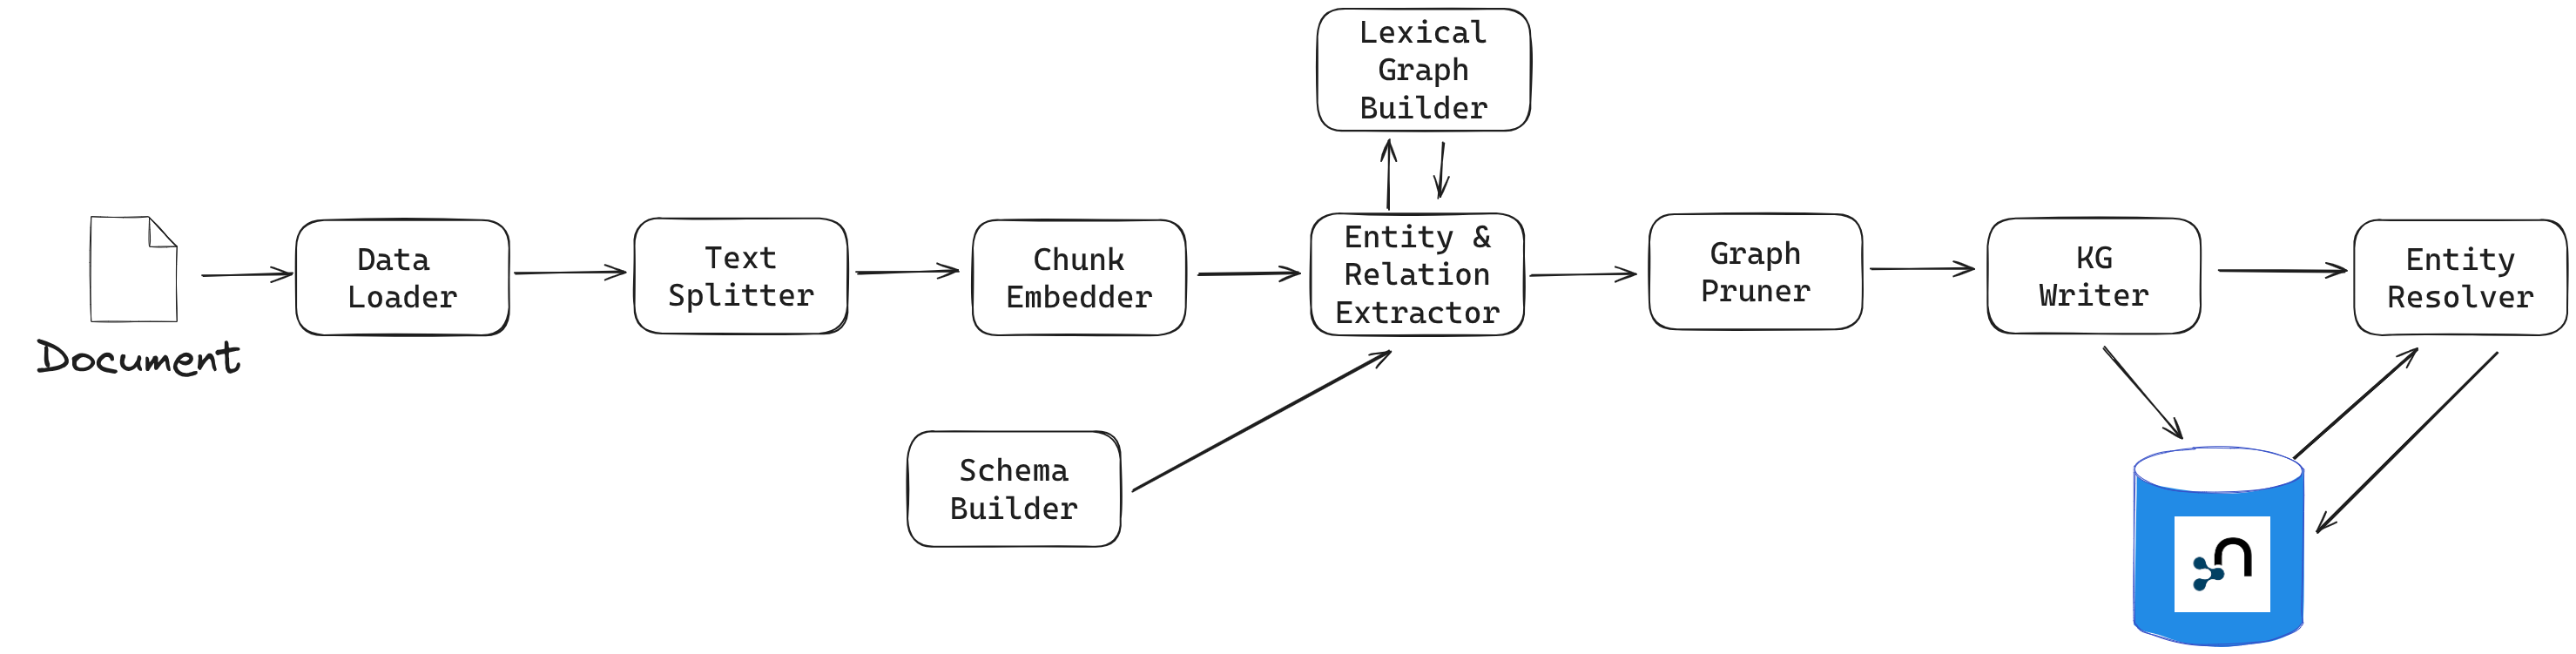

# Creating Components
Components are asynchronous units of work that perform simple tasks, such as chunking documents or saving results to Neo4j. This package includes a few default components, but developers can create their own custom components as well.

## 1. Data Loader
Data loaders start from a file path and return the text extracted from the input file.
This package currently supports text extraction from PDFs:

In [ ]:
# from pathlib import Path
# from neo4j_graphrag.experimental.components.pdf_loader import PdfLoader

# loader = PdfLoader()
# await loader.run(path=Path("my_file.pdf"))

We are implementing our own loader, using the DataLoader interface

Here, we are extracting the crawled text from a saved pickle file.

In [ ]:
from neo4j_graphrag.experimental.components.pdf_loader import DataLoader, PdfDocument
from pathlib import Path
import pickle

class PickleDataLoader(DataLoader):
    async def run(self, path: Path) -> PdfDocument:
        with open(path, "rb") as f:
            page_data = pickle.load(f)    # list of dicts
        return PdfDocument(
            text=str(page_data),
            document_info={"path": "page_data.pkl"} # Include the path here
        )

loader = PickleDataLoader()
# page_data = await loader.run(Path("page_data.pkl"))

## 2. Custom Text Splitter
Document splitters, as the name indicate, split documents into smaller chunks that can be processed within the LLM token limits.

In [ ]:
import ast
from urllib.parse import urlparse
from neo4j_graphrag.experimental.components.text_splitters.base import TextSplitter
from neo4j_graphrag.experimental.components.types import TextChunks, TextChunk, PdfDocument # Import PdfDocument

def extract_section_from_url(url: str) -> str:
    path = urlparse(url).path
    parts = [p for p in path.strip("/").split("/") if p]

    if "datahacksummit-2025" in parts:
        parts.remove("datahacksummit-2025")

    if parts:
        return parts[0].replace("-", " ").title()
    else:
        return "Overview"


class MyCustomTextSplitter(TextSplitter):
    def __init__(self, dataset_name: str = "AV Data Hack Summit"):
        self.dataset_name = dataset_name

    async def run(self, page_data: PdfDocument) -> TextChunks: # Type hint for clarity
        # Access the text attribute of the PdfDocument and apply ast.literal_eval
        #list_data = ast.literal_eval(page_data.text)
        list_data = ast.literal_eval(page_data["text"] if isinstance(page_data, dict) else page_data.text)
        chunks = []
        for i, entry in enumerate(list_data): # Iterate over the list_data
            section = extract_section_from_url(entry["url"])
            chunk = TextChunk(
                index=i,
                text=entry["content"],
                metadata={
                    "url": entry["url"],
                    "section": section,
                    "dataset": self.dataset_name
                }
            )
            chunks.append(chunk)
        return TextChunks(chunks=chunks)


splitter = MyCustomTextSplitter()
# The example usage below is now commented out or needs adjustment
# text_chunks = await splitter.run(ast.literal_eval(page_data.text))

## 3. Chunk Embedder
In order to embed the chunks’ texts (to be used in vector search RAG), one can use the TextChunkEmbedder component, which rely on the Embedder interface.

In [ ]:
from neo4j_graphrag.experimental.components.embedder import TextChunkEmbedder

text_chunk_embedder = TextChunkEmbedder(embedder=embedder)

# embeddings = await text_chunk_embedder.run(text_chunks=splits)

## 4. Schema Builder
The schema is used to try and ground the LLM to a list of possible node and relationship types of interest. So far, schema must be manually created by specifying:


*   Node types the LLM should look for in the text, including their properties (name and type).
*   Relationship types of interest between these node types, including the relationship properties (name and type)
*   Patterns (triplets) to define the start (source) and end (target) entity types for each relationship.


Here is a code block illustrating these concepts:

In [ ]:
from neo4j_graphrag.experimental.components.schema import (
    SchemaBuilder,
    NodeType,
    PropertyType,
    RelationshipType,
)

schema_builder = SchemaBuilder()


In [ ]:
# Define the possible node types
node_types = [
    NodeType(
        label="Speaker",
        description="An individual who presents or speaks at sessions, panels, keynote, opening remarks, or workshops.",
        properties=[
            {"name": "name", "type": "STRING", "description": "The full name of the speaker."},
            {"name": "organization", "type": "STRING", "description": "The organization the speaker is affiliated with."},
            {"name": "designation", "type": "STRING", "description": "The job title or role of the speaker within their organization."},
            {"name": "bio", "type": "STRING", "description": "A detailed and rich biography of the speaker."},
            {"name": "linkedin_url", "type": "STRING", "description": "The LinkedIn profile URL of the speaker."},
            {"name": "awards", "type": "LIST", "description": "A list of awards or recognitions received by the speaker."},
            {"name": "is_hackpanel", "type": "BOOLEAN", "description": "Indicates if the speaker is part of a hack panel."},
            {"name": "skills", "type": "LIST", "description": "A list of technical or professional skills the speaker possesses."},
            {"name": "interests", "type": "LIST", "description": "A list of the speaker's areas of interest."},
            {"name": "certifications", "type": "LIST", "description": "A list of certifications held by the speaker."},
        ],
    ),
    NodeType(
        label="Workshop",
        description="A hands-on technical day long session conducted during the conference.",
        properties=[
            {"name": "title", "type": "STRING", "description": "The title of the workshop."},
            {"name": "description", "type": "STRING", "description": "A rich summary or abstract of the workshop."},
            {"name": "instructor", "type": "STRING", "description": "The name(s) of the workshop instructor(s)."},
            {"name": "start_time", "type": "STRING", "description": "The start time of the workshop."},
            {"name": "level", "type": "STRING", "description": "The intended experience level for the workshop (e.g., 'beginner', 'intermediate', 'advanced')."},
            {"name": "prerequisites", "type": "LIST", "description": "A list of prerequisites for attending the workshop."},
            {"name": "tools_used", "type": "LIST", "description": "A list of tools or technologies used in the workshop."},
        ],
    ),
    NodeType(
        label="Session",
        description="A presentation or talk delivered during the conference.",
        properties=[
            {"name": "title", "type": "STRING", "description": "The title of the session."},
            {"name": "description", "type": "STRING", "description": "A rich summary or abstract of the session."},
            {"name": "instructor", "type": "STRING", "description": "The name(s) of the session instructor(s)."},
            {"name": "session_type", "type": "STRING","description": "The format of the session, e.g., Keynote, Hack Session, PowerTalk, Opening Remark, Closing Remarks Awards"},
            {"name": "theme", "type": "STRING", "description": "The main topic or track the session belongs to."},
            {"name": "tools_discussed", "type": "LIST", "description": "A list of tools or technologies discussed during the session."},
            {"name": "level", "type": "STRING", "description": "Intended experience level of the audience, e.g., beginner, intermediate, advanced."},
            {"name": "start_time", "type": "LOCAL_TIME", "description": "Start time of the session in HH:MM format"},
            {"name": "end_time", "type": "LOCAL_TIME", "description": "End time of the session in HH:MM format"},
            {"name": "day", "type": "STRING", "description": "On which day is the session being conducted - Day number of the event. e.g., Day 1, Day 2, Day 3"},
            {"name": "date", "type": "DATE", "description": "Date of the session in DD-MM-YYY format"},
        ],
    ),
    NodeType(
    label="Venue",
    description="Physical location of the session. e.g., ChatGPT, Gemini, Grok, Claude",
    properties=[
        {"name": "name", "type": "STRING", "description": "The name of the venue or room where the session or workshop or conference is held."},
    ]
),
    NodeType(
        label="Sponsor",
        description="An organization providing financial or logistical support for the conference.",
        properties=[
            {"name": "name", "type": "STRING", "description": "The name of the sponsoring organization."},
            {"name": "description", "type": "STRING", "description": "Rich description about the sponsoring company."},
        ],
    ),
    NodeType(
        label="Company",
        description="A business or organization affiliated with the speaker or sponsoring the conference.",
        properties=[
            {"name": "name", "type": "STRING", "description": "The name of the company."},
            {"name": "industry", "type": "STRING", "description": "The industry the company operates in."},
            {"name": "website", "type": "STRING", "description": "The official website of the company."},
        ],
    ),
    NodeType(
        label="University",
        description="A higher education institution.",
        properties=[
           {"name": "name", "type": "STRING", "description": "The name of the university."},
        ],
        ),
    NodeType(
        label="Conference",
        description="The DataHack Summit event as a whole.",
        properties=[
            {"name": "name", "type": "STRING", "description": "The name of the conference."},
            {"name": "year", "type": "INTEGER", "description": "The year the conference is held."},
            {"name": "location", "type": "STRING", "description": "The physical location where the conference takes place."},
            {"name": "theme", "type": "STRING", "description": "The overarching theme of the conference."},
        ],
    ),
    NodeType(
        label="Tool",
        description="AI/ML software, framework, or platform used during sessions or workshops.",
        properties=[
            {"name": "name", "type": "STRING", "description": "The name of the tool."},
            {"name": "type", "type": "STRING", "description": "The type of tool (e.g., 'framework', 'library', 'platform')."},
        ],
    ),
    NodeType(
        label="Topic",
        description="A subject area covered in a session or workshop (e.g., Agentic RAG, LLMs).",
        properties=[
            {"name": "name", "type": "STRING", "description": "The name of the topic."},
        ],
    ),
]

In [ ]:
# Define the relationships between the nodes
relationship_types = [
    RelationshipType(
        label="SPONSORS",
        description="Sponsor supports the Conference.",
        properties=[
            {"name": "description", "type": "STRING", "description": "Describes the relationship between the Sponsor (source) and the Conference(target)."}
        ]
    ),
    RelationshipType(
        label="PRESENTS",
        description="Person presents a Session.",
        properties=[
            {"name": "description", "type": "STRING", "description": "Describes the relationship between the Person (source) and Session (target)."}
        ]
    ),
    RelationshipType(
        label="CONDUCTS",
        description="Person conducts a Workshop.",
        properties=[
            {"name": "description", "type": "STRING", "description": "Describes the relationship between the Person (source) and Workshop (target)."}
        ]
    ),
    RelationshipType(
    label="HOSTED_AT",
    description="Session is hosted at a venue.",
    properties=[]
),

    RelationshipType(
        label="HOSTS",
        description="Conference hosts a Session or Workshop.",
        properties=[
            {"name": "description", "type": "STRING", "description": "Describes the relationship between the Conference (source) and Session/Workshop (target)."}
        ]
    ),
    RelationshipType(
        label="WORKS_FOR",
        description="Person is employed by a Company.",
        properties=[
            {"name": "description", "type": "STRING", "description": "Describes the relationship between the Person (source) and Company (target)."}
        ]
    ),
    RelationshipType(
        label="USES",
        description="Workshop or Session uses a Tool.",
        properties=[
            {"name": "description", "type": "STRING", "description": "Describes the relationship between the Workshop/Session (source) and Tool (target)."}
        ]
    ),
    RelationshipType(
        label="COVERS",
        description="Session or Workshop covers a Topic.",
        properties=[
            {"name": "description", "type": "STRING", "description": "Describes the relationship between the Session/Workshop (source) and Topic (target)."}
        ]
    ),
    RelationshipType(
        label="AFFILIATED_WITH",
        description="Person is affiliated with a University mentioned in their bio or context.",
        properties=[
            {"name": "description", "type": "STRING", "description": "Describes the nature of the affiliation."}
        ]
    ),

]



In [ ]:
# Define the possible patterns
patterns = [
    ("Conference", "HOSTS", "Workshop"),
    ("Conference", "HOSTS", "Session"),
	("Conference", "HOSTED_AT", "Venue"),
	("Sponsor", "SPONSORS", "Conference"),
    ("Speaker", "WORKS_FOR", "Company"),
    ("Speaker", "PRESENTS", "Session"),
    ("Speaker", "CONDUCTS", "Workshop"),
    ("Speaker", "WINS", "Award"),
    ("Speaker", "AFFILIATED_WITH", "University"),
	("Session", "USES", "Tool"),
    ("Session", "COVERS", "Topic"),
	("Session", "HOSTED_AT", "Venue"),
    ("Workshop", "USES", "Tool"),
    ("Workshop", "COVERS", "Topic"),
	("Workshop", "HOSTED_AT", "Venue"),

]

**Automatic Schema Extraction**

Instead of manually defining the schema, you can use the SchemaFromTextExtractor component to automatically extract a schema from your text using an LLM:

In [ ]:
# # Automatic Schema extraction
# from neo4j_graphrag.experimental.components.schema import SchemaFromTextExtractor
# from neo4j_graphrag.generation.prompts import PromptTemplate

# # Define a stricter prompt template that forces clean JSON output
# custom_prompt = """
# You are an expert in knowledge graph schema design.

# Given the following unstructured text, extract a schema in the following strict JSON format:

# {{
#   "node_types": [
#     {{"name": "EntityLabel", "properties": ["prop1", "prop2"]}}
#   ],
#   "relationship_types": [
#     {{"type": "RELATES_TO", "from": "EntityLabel", "to": "OtherEntity"}}
#   ]
# }}
# #
# # Rules:
# # - Respond ONLY with the JSON object above, populated with real values.
# # - Do NOT include Markdown formatting (like ```), comments, or explanation.
# #
# # Text:
# # {text}
# # """

# # Instantiate the automatic schema extractor component
# schema_extractor = SchemaFromTextExtractor(
#     llm=llm,
#     #prompt_template = PromptTemplate(template=custom_prompt)
# )

# # Convert TextChunks → single string
# full_text = "\n\n".join(chunk.text for chunk in text_chunks.chunks)

# # Extract the schema from the text
# extracted_schema = await schema_extractor.run(text=full_text)

# # View result
# from pprint import pprint
# pprint(extracted_schema.dict(), depth=4)

## 5. Lexical graph builder

Once the chunks are extracted and embedded (if required), a graph can be created.

The lexical graph contains:

*   Document node: represent the processed document and have a path property.
*   Chunk nodes: represent the text chunks. They have a text property and, if computed, an embedding property.
*   NEXT_CHUNK relationships between one chunk node and the next one in the document. It can be used to enhance the context in a RAG application.
*   FROM_DOCUMENT relationship between each chunk and the document it was built from.



In [ ]:
# from neo4j_graphrag.experimental.pipeline.components.lexical_graph_builder import LexicalGraphBuilder
# from neo4j_graphrag.experimental.pipeline.components.types import LexicalGraphConfig

# lexical_graph_builder = LexicalGraphBuilder(config=LexicalGraphConfig())
# graph = await lexical_graph_builder.run(
#     text_chunks=TextChunks(chunks=[
#         TextChunk(text="some text", index=0),
#         TextChunk(text="some text", index=1),
#     ]),
#     document_info=DocumentInfo(path="my_document.pdf"),
# )

## 6. Entity and Relation Extractor
This component is responsible for extracting the relevant entities and relationships from each text chunk, using the schema as guideline.

This package contains an LLM-based entity and relationships extractor: LLMEntityRelationExtractor. It can be used in this way:

In [ ]:
from neo4j_graphrag.experimental.components.entity_relation_extractor import (
    LLMEntityRelationExtractor,
    OnError,
)


entity_extractor = LLMEntityRelationExtractor(
    llm=llm,
    on_error=OnError.RAISE,
    create_lexical_graph=False,
    prompt_template=prompts.ENTITY_RELATION_EXTRACTOR_PROMPT,
)

#await entity_extractor.run(chunks=text_chunks, schema=extracted_schema)

## 7. Entity Resolver

The KG Writer component creates new nodes for each identified entity without making assumptions about entity similarity. The Entity Resolver is responsible for refining the created knowledge graph by merging entity nodes that represent the same real-world object.

In practice, this package implements three resolvers:

- a simple resolver that merges nodes with the same label and identical “name” property;

- two similarity-based resolvers that merge nodes with the same label and similar set of textual properties (by default they use the “name” property):

    -a semantic match resolver, which is based on spaCy embeddings and cosine similarities of embedding vectors. This resolver is ideal for higher quality KG resolution using static embeddings.

    -a fuzzy match resolver, which is based on RapidFuzz for Rapid fuzzy string matching using the Levenshtein Distance. This resolver offers faster ingestion speeds by using string similarity measures, at the potential cost of resolution precision.

In [ ]:
from neo4j_graphrag.experimental.components.resolver import FuzzyMatchResolver

resolver = FuzzyMatchResolver(driver)  # fuzzy match with RapidFuzz

#res = await resolver.run()

## 8. Graph Pruner
 Standard Usage: Pruner Is Automatic via Schema
The graph pruner is usually invoked automatically based on your schema enforcement settings. When building your pipeline with either SimpleKGPipeline or a custom Pipeline, you do not need to add a separate graph pruner component. Instead:

Specify your schema (node types, relationship types, patterns, required properties, etc.), either as a dictionary or GraphSchema object.

The pipeline uses this schema for extraction and pruning at the correct stage.

— The graph pruner will run automatically after extraction, pruning any nodes or relationships that do not match your schema (including missing required properties).

## 9. KG Writer
KG writer are used to save the results of the EntityRelationExtractor. The main implementation is the Neo4jWriter that will write nodes and relationships to a Neo4j database:

In [ ]:
from neo4j_graphrag.experimental.components.kg_writer import Neo4jWriter

eg_writer = Neo4jWriter(
        driver,
        # optionally, configure the neo4j database
        # neo4j_database="neo4j",
        # you can tune batch_size to
        # improve speed
        # batch_size=1000,
    )
#result = await writer.run(graph=graph)

# Custom Components

## 10. Custom Deduplication Component

In [ ]:
from neo4j_graphrag.experimental.pipeline import Component, DataModel

class Neo4jWorkshopDedupResult(DataModel):
    merged_workshop_count: int
    merged_session_count: int

class Neo4jWorkshopMergeAndDeduplicate(Component):
    """
    Merges duplicate Workshop nodes (by title) and deduplicates all array properties.
    """

    def __init__(self, driver):
        self.driver = driver

    def merge_duplicates(self) -> int:
        """
        Merges Workshop nodes with the same title, combining properties and relationships.
        Returns the number of merge operations done.
        """
        merge_query = """
        MATCH (n:Workshop)
        WITH n.title AS title, collect(n) AS nodes
        WHERE size(nodes) > 1
        CALL apoc.refactor.mergeNodes(nodes, {properties: 'combine', mergeRels: true}) YIELD node
        RETURN count(node) AS merged_count
        """
        with self.driver.session() as session:
            result = session.run(merge_query)
            merged = result.single()["merged_count"]
        return merged

    def merge_session_duplicates(self) -> int:
      """
      Merges Session nodes with the same title, combining properties and relationships.
      Returns the number of merge operations done.
      """
      merge_query = """
      MATCH (n:Session)
      WITH n.title AS title, collect(n) AS nodes
      WHERE size(nodes) > 1 AND title IS NOT NULL
      CALL apoc.refactor.mergeNodes(nodes, {properties: 'combine', mergeRels: true}) YIELD node
      RETURN count(node) AS merged_count
      """
      with self.driver.session() as session:
          result = session.run(merge_query)
          merged = result.single()["merged_count"]
      return merged


    async def run(self) -> Neo4jWorkshopDedupResult:
        # Merge duplicate nodes
        merged_workshops = self.merge_duplicates()
        merged_sessions = self.merge_session_duplicates()
        print(f"Merged {merged_workshops} duplicate Workshop nodes.")
        print(f"Merged {merged_sessions} duplicate Session nodes.")

        return Neo4jWorkshopDedupResult(merged_workshop_count=merged_workshops, merged_session_count=merged_sessions)

# Example usage in a pipeline:
dedup_processor = Neo4jWorkshopMergeAndDeduplicate(driver)
#result = dedup_processor.run()

## 11. Entity Embedder

In [ ]:
class EmbedEntityResult(DataModel):
    updated_count: int

class EntityTextEmbedder(Component):
    def __init__(self, driver, label="__Entity__", embedder=None):
        self.driver = driver
        self.label = label
        self.embedder = embedder

    async def run(self) -> EmbedEntityResult:
        updated = 0
        with self.driver.session() as session:
            result = session.run(
                f"MATCH (e:`{self.label}`) RETURN elementId(e) AS id, properties(e) AS props"
            )
            for record in result:
                node_id = record["id"]
                props = record["props"]
                str_props = {k: v for k, v in props.items() if isinstance(v, str)}
                if not str_props:
                    continue
                prop_name, text = max(str_props.items(), key=lambda item: len(item[1]))
                embedding = self.embedder.embed_query(text)
                session.run(
                    """
                    MATCH (e)
                    WHERE elementId(e) = $id
                    SET e.embedding = $embedding
                    """, id=node_id, embedding=embedding
                )
                updated += 1
        print("Embeddings created for entities")
        return EmbedEntityResult(updated_count=updated)

entity_embedder = EntityTextEmbedder(driver=driver, embedder=embedder)

## 12. Community Detection & Summarization

A custom pipeline component that performs both community detection and summarization

In [ ]:
from tqdm import tqdm
from typing import Dict, Any
import cypher
from pydantic import Field

class CommunityDetectionResultModel(DataModel):
    # You can extend this model depending on what outputs you want
    node_communities: list = Field(default_factory=list)


class CommunityDetectionAndSummarization(Component):
    """
    A custom pipeline component that performs both community detection and summarization.
    """
    def __init__(self, llm, neo4j_driver):
      super().__init__()
      self.llm = llm
      self.neo4j_driver = neo4j_driver

    def add_entity_id_if_missing(self):

      with self.neo4j_driver.session() as session:
          result = session.run(cypher.cypher_add_entity_id)
          updated_count = result.single()["updated_count"]
          print(f"Assigned entity_id to {updated_count} nodes.")
          #self.neo4j_driver.execute_query("CREATE CONSTRAINT FOR (n:__Entity__) REQUIRE n.entity_id IS UNIQUE")

    def calculate_communities(self):
        # Drop existing projection if it exists
        try:
            self.neo4j_driver.execute_query("CALL gds.graph.drop('communityGraph', false)")
        except Exception:
            pass


        self.neo4j_driver.execute_query(cypher.projection_query)

        records, _, _ = self.neo4j_driver.execute_query(cypher.louvain_query)
        return records[0].data()

    def community_info(self):

        result, _, _ = self.neo4j_driver.execute_query(cypher.community_info_query)
        return result

    def get_summarize_community_prompt(self, nodes, relationships):
        input_text = f"""Entities\n\n{nodes}\n\nRelationships\n\n{relationships}\n"""
        return prompts.COMMUNITY_REPORT_PROMPT.format(
            input_text=input_text,
        )

    def summarize_communities(self, community_info):
        from langchain_core.output_parsers import JsonOutputParser
        from langchain_core.runnables import RunnableLambda
        json_parser = JsonOutputParser()
        generate_prompt = RunnableLambda(
            lambda inputs: self.get_summarize_community_prompt(inputs["nodes"], inputs["rels"])
        )
        community_chain = generate_prompt | self.llm | json_parser

        communities = []
        for community in tqdm(community_info, desc="Summarizing communities"):
            result = community_chain.invoke({
                "nodes": community["nodes"],
                "rels": community["rels"]
            })
            communities.append({
                "community": result,
                "communityId": community["communityId"],
                "nodes": [el["id"] for el in community["nodes"]],
            })
        return communities

    def prepare_communities_for_neo4j(self, communities):
        fixed_communities = []
        for row in tqdm(communities, desc="Fixing community node format"):
            fixed_nodes = [
                {"entity_id": nid.strip()}
                for nid in row["nodes"]
                if nid and isinstance(nid, str) and nid.strip()
            ]
            fixed_communities.append({
                "communityId": row["communityId"],
                "community": row["community"],  # structured dict
                "nodes": fixed_nodes,
                "rels": row.get("rels", [])
            })
        return fixed_communities

    async def run(self, **kwargs) -> CommunityDetectionResultModel:
        # Add entity ids
        self.add_entity_id_if_missing()

        # Step 1: Run Louvain community detection
        self.calculate_communities()

        # Step 2: Extract community info
        community_info = self.community_info()

        # Step 3: Summarize each community
        communities = self.summarize_communities(community_info)
        communities_fixed = self.prepare_communities_for_neo4j(communities)

        # Step 4: Ingest into Neo4j
        self.neo4j_driver.execute_query(cypher.import_community_query, data=communities_fixed)

        return CommunityDetectionResultModel(node_communities=communities_fixed)

community_detector = CommunityDetectionAndSummarization(llm=lang_llm, neo4j_driver=driver)

# Connecting Components within a Pipeline
The ultimate aim of creating components is to assemble them into a complex pipeline for a specific purpose, such as building a Knowledge Graph from text data.

Here’s how to create a simple pipeline and propagate results from one component to another (detailed explanations follow):

In [ ]:
import asyncio
from neo4j_graphrag.experimental.pipeline import Pipeline
from neo4j_graphrag.experimental.components.schema import SchemaBuilder # Ensure SchemaBuilder is imported

pipe = Pipeline()

# ✅ Add your custom loader and splitter
pipe.add_component(loader, "data_loader")
pipe.add_component(splitter, "text_splitter")

# ✅ Add other components
pipe.add_component(text_chunk_embedder, "chunk_embedder")
pipe.add_component(schema_builder, "schema") # Instantiate SchemaBuilder
pipe.add_component(entity_extractor, "entity_extractor")
pipe.add_component(resolver, "resolver")
pipe.add_component(eg_writer, "eg_writer")
pipe.add_component(dedup_processor, "dedup_processor")
pipe.add_component(entity_embedder, "entity_embedder")
pipe.add_component(community_detector, "community_detector")



# ✅ Connect components
# Connect the output of the data_loader (pdf_doc) to the text_splitter
pipe.connect("data_loader", "text_splitter", input_config={"page_data": "data_loader"})

# Connect text_splitter output to chunk_embedder
pipe.connect("text_splitter", "chunk_embedder", input_config={"text_chunks": "text_splitter"})

# Connect chunk_embedder output (chunks) to entity_extractor
pipe.connect("chunk_embedder", "entity_extractor", input_config={"chunks": "chunk_embedder"})

# Connect schema component output to entity_extractor
pipe.connect("schema", "entity_extractor", input_config={"schema": "schema"})

# Connect entity_extractor output (graph) to eg_writer
pipe.connect("entity_extractor", "eg_writer", input_config={"graph": "entity_extractor"})

# Connect eg_writer output to resolver, entity_embedder, and community_detector
pipe.connect("eg_writer", "resolver", {}) # Resolver likely operates on the database written to by eg_writer, so no direct data passing needed here usually.

pipe.connect("eg_writer", "dedup_processor", {}) # Deduplication processor also likely operates on the database.

pipe.connect("eg_writer", "entity_embedder", {}) # Entity embedder also likely operates on the database.

pipe.connect("eg_writer", "community_detector", {}) # Community detector likely operates on the database.

# ✅ Define inputs for the pipeline (will be passed to the first component, data_loader)
pipe_inputs = {
    "data_loader": {
        "path": Path("page_data.pkl") # Input for the data_loader
    },
    # Inputs for other components that don't rely on previous component outputs
    "schema": {
            "node_types": node_types,
            "relationship_types": relationship_types,
            "patterns": patterns,
        },
}

# ✅ Run the pipeline
await pipe.run(pipe_inputs)

Merged 10 duplicate Workshop nodes.
Merged 33 duplicate Session nodes.
Embeddings created for entities
Assigned entity_id to 394 nodes.


Fixing community node format: 100%|██████████| 14/14 [00:00<00:00, 46529.52it/s]


PipelineResult(run_id='a9a2538f-c5ac-4b5b-9469-e36adce771c4', result={'resolver': {'number_of_nodes_to_resolve': 866, 'number_of_created_nodes': 147}, 'dedup_processor': {'merged_workshop_count': 10, 'merged_session_count': 33}, 'entity_embedder': {'updated_count': 394}, 'community_detector': {'node_communities': [{'communityId': 108, 'community': {'title': 'Agentic AI and Multi-Agent Systems Community: Key Entities and Technical Ecosystem', 'summary': "This community centers on the development, application, and instruction of Agentic AI and Multi-Agent Systems, involving prominent individuals such as Bhaskarjit Sarmah, Alessandro Romano, Mohsin Hasan Khan, and Shubhradeep Nandi. The network is characterized by a strong focus on technical tools (Python, Streamlit, OpenAI Functions, custom agent frameworks), advanced AI topics (fraud detection, credit risk assessment, financial oversight, welfare benefit approval), and the involvement of major organizations (Domyn, BlackRock, Kuehne+Nag